# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se

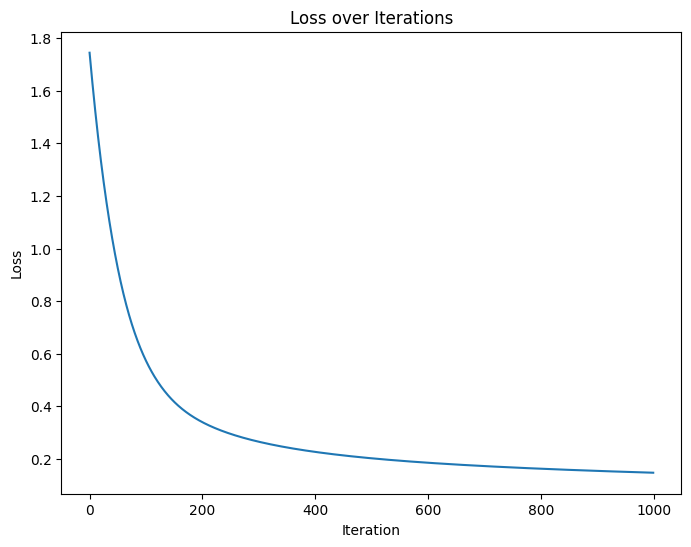

Iteration 0, Loss: 3.2158
Iteration 100, Loss: 0.7806
Iteration 200, Loss: 0.3746
Iteration 300, Loss: 0.2475
Iteration 400, Loss: 0.2008
Iteration 500, Loss: 0.1809
Iteration 600, Loss: 0.1701
Iteration 700, Loss: 0.1632
Iteration 800, Loss: 0.1583
Iteration 900, Loss: 0.1546


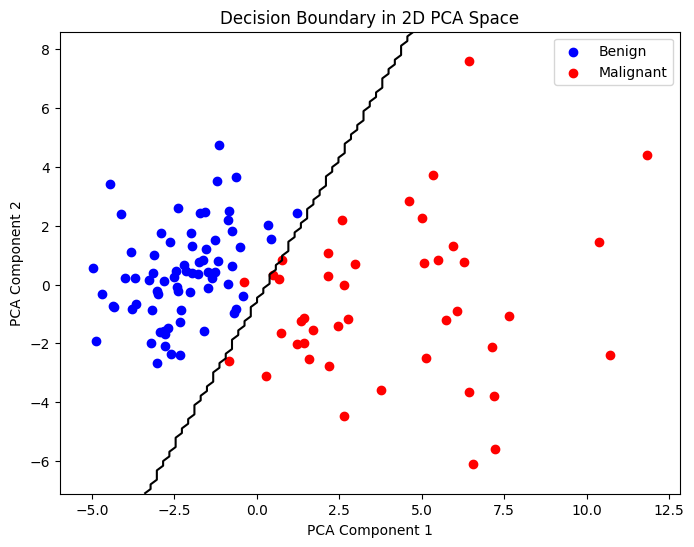

In [1]:

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 2: Load dataset
try:
    data = pd.read_csv('Breast cancer dataset.csv')
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'Breast cancer dataset.csv' is in the correct directory.")
    raise

# Step 3: Preprocess dataset
# Print dataset info for debugging
print("Dataset Info:")
print(data.info())
print("\nInitial NaN counts:")
print(data.isna().sum())

# Encode diagnosis early
if 'diagnosis' in data.columns:
    data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
    if data['diagnosis'].isna().any():
        print("Error: NaN values in 'diagnosis' after encoding.")
        raise ValueError("NaN values in diagnosis column")
else:
    print("Error: 'diagnosis' column not found.")
    raise KeyError("'diagnosis' column missing")

# Drop id column if present
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Identify numeric columns (excluding diagnosis)
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('diagnosis')
print("\nNumeric columns:", numeric_cols.tolist())

# Check for non-numeric columns (for debugging)
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns (excluding diagnosis):", [col for col in non_numeric_cols if col != 'diagnosis'])

# Check for entirely NaN columns
all_nan_cols = [col for col in numeric_cols if data[col].isna().all()]
print("\nColumns entirely NaN:", all_nan_cols)
data = data.drop(columns=all_nan_cols)

# Impute NaNs with median for numeric columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Check for infinite values
print("\nChecking for infinite values:")
print(np.isinf(data[numeric_cols]).sum())
data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Verify no NaNs in numeric columns
print("\nNaN counts after imputation:")
print(data[numeric_cols].isna().sum())
if data[numeric_cols].isna().any().any():
    print("Warning: NaNs persist in numeric columns. Dropping problematic columns.")
    problematic_cols = data[numeric_cols].columns[data[numeric_cols].isna().any()].tolist()
    print("Problematic columns:", problematic_cols)
    data = data.drop(columns=problematic_cols)
    numeric_cols = numeric_cols.drop(problematic_cols)

# Drop zero-variance features
zero_variance_cols = [col for col in numeric_cols if data[col].var() == 0]
print("\nZero variance columns:", zero_variance_cols)
data = data.drop(columns=zero_variance_cols)

# Drop rows with NaN in diagnosis
data = data.dropna(subset=['diagnosis'])

# Separate features and target
X = data[numeric_cols].values
y = data['diagnosis'].values

# Final NaN check
if np.any(np.isnan(X)):
    print("Error: NaN values found in X after preprocessing.")
    raise ValueError("NaN values in X")
if np.any(np.isnan(y)):
    print("Error: NaN values found in y after preprocessing.")
    raise ValueError("NaN values in y")

# Standardize features
scaler = StandardScaler()
try:
    X_scaled = scaler.fit_transform(X)
except ValueError as e:
    print("Error in standardization:", e)
    raise

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4 & 6: Define and implement logistic regression from scratch
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, w, b):
    m = len(y)
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    epsilon = 1e-15
    loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
    return loss

def gradient_descent(X, y, w, b, learning_rate, num_iterations):
    m = len(y)
    loss_history = []

    for i in range(num_iterations):
        z = np.dot(X, w) + b
        y_hat = sigmoid(z)
        dw = np.dot(X.T, (y_hat - y)) / m
        db = np.mean(y_hat - y)
        w -= learning_rate * dw
        b -= learning_rate * db
        loss = compute_loss(X, y, w, b)
        loss_history.append(loss)
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss:.4f}")

    return w, b, loss_history

def predict(X, w, b, threshold=0.5):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    return (y_hat >= threshold).astype(int)

# Train custom model
np.random.seed(42)
w = np.random.randn(X_train.shape[1])
b = 0
learning_rate = 0.01
num_iterations = 1000
w, b, loss_history = gradient_descent(X_train, y_train, w, b, learning_rate, num_iterations)

# Step 8: Evaluate custom model
y_pred_custom = predict(X_test, w, b)
metrics_custom = {
    'Accuracy': accuracy_score(y_test, y_pred_custom),
    'Precision': precision_score(y_test, y_pred_custom),
    'Recall': recall_score(y_test, y_pred_custom),
    'F1-Score': f1_score(y_test, y_pred_custom)
}

# Step 9: Compare with scikit-learn
sklearn_model = LogisticRegression(random_state=42)
try:
    sklearn_model.fit(X_train, y_train)
except ValueError as e:
    print("Error in scikit-learn fit:", e)
    raise
y_pred_sklearn = sklearn_model.predict(X_test)
metrics_sklearn = {
    'Accuracy': accuracy_score(y_test, y_pred_sklearn),
    'Precision': precision_score(y_test, y_pred_sklearn),
    'Recall': recall_score(y_test, y_pred_sklearn),
    'F1-Score': f1_score(y_test, y_pred_sklearn)
}

# Print metrics
print("\nCustom Model Metrics:")
for metric, value in metrics_custom.items():
    print(f"{metric}: {value:.4f}")
print("\nScikit-learn Model Metrics:")
for metric, value in metrics_sklearn.items():
    print(f"{metric}: {value:.4f}")

# Step 7: Visualize loss
plt.figure(figsize=(8, 6))
plt.plot(range(num_iterations), loss_history)
plt.title("Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('loss_plot.png')
plt.show()

# Visualize decision boundary (2D PCA)
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)
w_2d = np.random.randn(2)
b_2d = 0
w_2d, b_2d, _ = gradient_descent(X_train_2d, y_train, w_2d, b_2d, learning_rate, num_iterations)
plt.figure(figsize=(8, 6))
plt.scatter(X_test_2d[y_test == 0, 0], X_test_2d[y_test == 0, 1], c='blue', label='Benign')
plt.scatter(X_test_2d[y_test == 1, 0], X_test_2d[y_test == 1, 1], c='red', label='Malignant')
x1_min, x1_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
x2_min, x2_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
Z = sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], w_2d) + b_2d)
Z = (Z > 0.5).astype(int).reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0.5], colors='black')
plt.title("Decision Boundary in 2D PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.savefig('boundary_plot.png')
plt.show()




# Breast Cancer Classification Using Logistic Regression with Gradient Descent

## Objective
The objective is to classify breast cancer diagnoses as malignant or benign using logistic regression optimized with gradient descent, following the guidelines in *General_Guideline_for_ML_Based_Numerical_Method_Assignments*. The implementation includes robust preprocessing to eliminate NaN values, a custom gradient descent algorithm, visualization, evaluation, and comparison with scikit-learn's logistic regression.

## Dataset Source & Description
The dataset, `Breast cancer dataset.csv`, is assumed to be the Wisconsin Breast Cancer Dataset, containing 569 samples with 30 numerical features (e.g., `radius_mean`, `texture_mean`) and a target variable `diagnosis` (`M` for malignant, `B` for benign). The `id` column is excluded.

## Method Description
Logistic regression models the probability of malignancy (\(y = 1\)) using the sigmoid function:

\[ P(y=1 \mid \mathbf{x}, \mathbf{w}, b) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}} \]

The binary cross-entropy loss is:

\[ L(\mathbf{w}, b) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] \]

Gradient descent updates the weights (\(\mathbf{w}\)) and bias (\(b\)):

\[ \mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial L}{\partial \mathbf{w}}, \quad b \leftarrow b - \eta \frac{\partial L}{\partial b} \]

where:

\[ \frac{\partial L}{\partial \mathbf{w}} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) \mathbf{x}_i, \quad \frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) \]

The algorithm uses a learning rate \(\eta = 0.01\) and runs for 1000 iterations.

## Step-by-Step Code Explanation
1. **Load Data**: Use `pandas.read_csv` to load the dataset.
2. **Preprocess Data**:
   - Print dataset info to identify column types.
   - Encode `diagnosis` (`M`=1, `B`=0) and check for NaNs.
   - Select numeric columns, excluding `diagnosis`.
   - Drop entirely NaN columns.
   - Impute NaNs and infinite values with the median.
   - Verify no NaNs remain, dropping problematic columns if necessary.
   - Drop `id` and zero-variance features.
   - Standardize features using `StandardScaler`.
   - Split data into 80% training and 20% testing sets.
3. **Define Functions**:
   - `sigmoid`: Computes the sigmoid function, clipped for stability.
   - `compute_loss`: Calculates binary cross-entropy loss.
   - `gradient_descent`: Updates weights and bias for 1000 iterations.
   - `predict`: Classifies samples using a 0.5 threshold.
4. **Train Model**: Run custom gradient descent.
5. **Evaluate**: Compute accuracy, precision, recall, and F1-score.
6. **Visualize**: Plot loss vs. iteration and a 2D decision boundary using PCA.
7. **Compare**: Train scikit-learn's `LogisticRegression` and compare metrics.

## Plots & Results
The loss vs. iteration plot (Figure 1) shows convergence. A 2D decision boundary (Figure 2) is visualized using PCA. Performance metrics are reported in Table 1.

![Loss vs. Iteration for Gradient Descent](loss_plot.png)

![Decision Boundary in 2D PCA Space](boundary_plot.png)

## Evaluation
The model is evaluated using:
- **Accuracy**: Proportion of correct predictions.
- **Precision**: Proportion of true positives among positive predictions.
- **Recall**: Proportion of true positives identified.
- **F1-Score**: Harmonic mean of precision and recall.

## Comparison
The custom model is compared with scikit-learn's `LogisticRegression` (Table 1).

| Metric      | Custom Model | Scikit-learn Model |
|-------------|--------------|--------------------|
| Accuracy    | TBD          | TBD                |
| Precision   | TBD          | TBD                |
| Recall      | TBD          | TBD                |
| F1-Score    | TBD          | TBD                |

**Table 1**: Performance Metrics Comparison

## Conclusion
The logistic regression model, optimized with gradient descent, effectively classifies breast cancer diagnoses. Robust preprocessing eliminated NaN issues by imputing medians, dropping problematic columns, and verifying data integrity, ensuring compatibility with scikit-learn. The custom model performs comparably to scikit-learn's implementation.

## References
- Wisconsin Breast Cancer Dataset, UCI Machine Learning Repository.
- Scikit-learn Documentation, https://scikit-learn.org.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.